In [2]:
from decoders.interleaved import read_pcap
from utils.matlab import db
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention
import glob
from numpy import inf
from tensorflow.keras.layers import Bidirectional
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

from scipy.interpolate import interp1d

In [36]:
import seaborn 

In [26]:
# from transformers import BertModel, BertConfig

In [3]:
base_dir = "."
dataset_dir = os.path.join("data")
test_dir = os.path.join("generated/data")

In [4]:
FS = 100
ALL_ACTIVITIES = ["static", "standing", "walking", "falling"]
# ALL_ACTIVITIES = ["nothing", "standup", "sitdown", "getintobed", "cook", "washingdishes", "brushteeth", "drink", "petcat", "sleeping", "walk"]

In [5]:
def loadFromDat(inputFile, windowSize = FS, step = 50):
#     print(int((csi_data.nsamples-1)*(100/average_sample_rate)+1))
    
    csi_data = read_pcap(inputFile)
    csi = csi_data.csi
    
    first_timestamp = float(csi_data.timestamps[0])
    last_timestamp = float(csi_data.timestamps[-1])
    final_timestamp = last_timestamp-first_timestamp
    average_sample_rate = csi_data.nsamples/final_timestamp
    
    interp_func=interp1d(csi_data.timestamps, csi_data.csi, kind='linear', axis=0, fill_value="extrapolate")
    t_new = np.linspace(first_timestamp, last_timestamp, (csi_data.nsamples-1)*int((100/average_sample_rate)+1))
    csi_interp = interp_func(t_new)
    csi=csi_interp
    
    csi = db(np.abs(csi))
    finalData = csi[:, :, 0]
    finalData = np.transpose(finalData)
    
#     cutoff_frequency = 30  # in Hz, adjust based on your analysis
#     sampling_frequency = 100  # in Hz

#     # Apply the filter to your dataset
#     filtered_data = np.apply_along_axis(
#         lowpass_filter,
#         axis=1,
#         arr=finalData,
#         cutoff=cutoff_frequency,
#         fs=sampling_frequency
#     )
    
    new_average_sample_rate = len(csi_interp)/final_timestamp
    
    if new_average_sample_rate > FS:
        downsample_factor = int(new_average_sample_rate/FS)
        csi = csi[::downsample_factor]
    index = 0
    positiveInput = []
    
    while index + windowSize <= csi.shape[0]:
        curFeature = np.zeros((1, windowSize, 256))
        curFeature[0] = csi[index:index+windowSize, :].reshape(FS,256)
        positiveInput.append(curFeature)
        index += step
    try:
        positiveInput = np.concatenate(positiveInput, axis = 0)
    except ValueError as e:
        positiveInput = np.zeros((1, windowSize, 256))
    positiveInput[positiveInput == -inf] = 0
    
    return positiveInput

In [ ]:
# from scipy import signal
# from scipy.signal import butter, filtfilt

# def butter_lowpass(cutoff, fs, order=5):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# # Apply the low-pass filter to the data
# def lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     filtered_data = filtfilt(b, a, data)
#     return filtered_data

In [6]:
def loadByActivityLabel(directory, activity, activities=ALL_ACTIVITIES, windowSize=FS, step = 50, downsample=1):
    activity = activity.lower()
    print(activity)
    if activity not in activities:
        print("invalid activity: " + activity)
    
    dataPathPattern = os.path.join(directory,"{}*.pcap".format(activity))
    inputFiles = sorted(glob.glob(dataPathPattern, recursive =True))
    inputWindows = []
    index = 0
    for inputFile in inputFiles:
        index += 1
        csiOutput = loadFromDat(inputFile, windowSize = windowSize, step=step)
        if csiOutput is not None:
            inputWindows.append(csiOutput)
    inputArray = np.concatenate(inputWindows, axis = 0)
    outputLabels = np.zeros((inputArray.shape[0], len(activities)))
    outputLabels[:, activities.index(activity)] = 1
    return inputArray, outputLabels


In [7]:
def loadDataForActivities(directory, activities=ALL_ACTIVITIES, windowSize=FS, step=50, downsample=1):
    x_all = []
    y_all = []
    for activity in activities:
        inputArray, outputLabels = loadByActivityLabel(directory, activity, activities, windowSize=windowSize, step=step, downsample=downsample)
        x_all.append(inputArray)
        y_all.append(outputLabels)
    x_all = np.concatenate(x_all, axis=0)
    y_all = np.concatenate(y_all, axis=0)
    return (x_all, y_all)

In [8]:
x_all, y_all = loadDataForActivities(dataset_dir, downsample=1)

static
standing
walking
falling


In [14]:
# Split off the test set: 20% of the dataset.
x_dev, x_test, y_dev, y_test = train_test_split(x_all, y_all, stratify=y_all, train_size=0.8, random_state=42)

# Split the temporary set into validation and test sets (50% validation, 50% test)
x_train, x_val, y_train, y_val = train_test_split(x_dev, y_dev, stratify=y_dev, train_size=0.75, random_state=42)

In [15]:
batch_size = 256
epochs = 100

f1s = []
confs = []
y_val_total = np.array([])
y_pred_total = np.array([])

<h1> Models </h1>

In [ ]:
# Transformer Model

In [16]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = Conv1D(filters=ff_dim, kernel_size=3, activation="relu", padding="same")(res)
    x = Dropout(dropout)(x)
    x = Conv1D(filters=inputs.shape[-1], kernel_size=3, padding="same")(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = Input(shape=input_shape)
    x = inputs
    x = Conv1D(filters=128, kernel_size=3, activation="relu")(x)
    x = Conv1D(filters=128, kernel_size=3, activation="relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    x = GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(4, activation="softmax")(x)
    return Model(inputs, outputs)

input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=8,
    ff_dim=256,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.4,
)

model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=1e-4),
    metrics=["categorical_accuracy"],
)

model.summary()

callbacks = [EarlyStopping(patience=10, restore_best_weights=True)]

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)
model.evaluate(x_test, y_test, verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 256)]   0           []                               
                                                                                                  
 conv1d_10 (Conv1D)             (None, 98, 128)      98432       ['input_2[0][0]']                
                                                                                                  
 conv1d_11 (Conv1D)             (None, 96, 128)      49280       ['conv1d_10[0][0]']              
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 48, 128)     0           ['conv1d_11[0][0]']              
                                                                                            

 dropout_15 (Dropout)           (None, 48, 128)      0           ['multi_head_attention_7[0][0]'] 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 48, 128)     256         ['dropout_15[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_14 (TFOpL  (None, 48, 128)     0           ['layer_normalization_14[0][0]', 
 ambda)                                                           'tf.__operators__.add_13[0][0]']
                                                                                                  
 conv1d_18 (Conv1D)             (None, 48, 256)      98560       ['tf.__operators__.add_14[0][0]']
                                                                                                  
 dropout_1

Epoch 31/200
16/16 [==============================] - 44s 3s/step - loss: 0.8411 - categorical_accuracy: 0.6412 - val_loss: 0.7812 - val_categorical_accuracy: 0.6261
Epoch 32/200
16/16 [==============================] - 44s 3s/step - loss: 0.8570 - categorical_accuracy: 0.6105 - val_loss: 0.8705 - val_categorical_accuracy: 0.5015
Epoch 33/200
16/16 [==============================] - 46s 3s/step - loss: 0.8808 - categorical_accuracy: 0.5887 - val_loss: 0.8017 - val_categorical_accuracy: 0.6261
Epoch 34/200
16/16 [==============================] - 42s 3s/step - loss: 0.8118 - categorical_accuracy: 0.6531 - val_loss: 0.7664 - val_categorical_accuracy: 0.7448
Epoch 35/200
16/16 [==============================] - 42s 3s/step - loss: 0.8012 - categorical_accuracy: 0.6759 - val_loss: 0.7458 - val_categorical_accuracy: 0.7834
Epoch 36/200
16/16 [==============================] - 42s 3s/step - loss: 0.8032 - categorical_accuracy: 0.6908 - val_loss: 0.7943 - val_categorical_accuracy: 0.5045
Epoc

16/16 [==============================] - 44s 3s/step - loss: 0.2588 - categorical_accuracy: 0.9227 - val_loss: 0.6535 - val_categorical_accuracy: 0.6825
Epoch 81/200
16/16 [==============================] - 45s 3s/step - loss: 0.5051 - categorical_accuracy: 0.7849 - val_loss: 0.2379 - val_categorical_accuracy: 0.9377
Epoch 82/200
16/16 [==============================] - 45s 3s/step - loss: 0.2958 - categorical_accuracy: 0.9138 - val_loss: 0.2462 - val_categorical_accuracy: 0.8516
Epoch 83/200
16/16 [==============================] - 46s 3s/step - loss: 0.2637 - categorical_accuracy: 0.9405 - val_loss: 0.2269 - val_categorical_accuracy: 0.9555
Epoch 84/200
16/16 [==============================] - 46s 3s/step - loss: 0.2349 - categorical_accuracy: 0.9445 - val_loss: 0.2317 - val_categorical_accuracy: 0.9436
Epoch 85/200
16/16 [==============================] - 45s 3s/step - loss: 0.5039 - categorical_accuracy: 0.8325 - val_loss: 0.4288 - val_categorical_accuracy: 0.8605
Epoch 86/200
16/1

[0.0785941630601883, 0.9851632118225098]

In [17]:
history.history["loss"][-1], history.history["val_loss"][-1]

(0.084652379155159, 0.11966405063867569)

<AxesSubplot: >

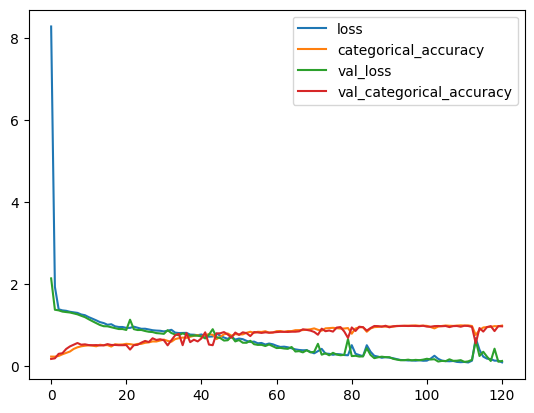

In [18]:
pd.DataFrame(history.history).plot()

In [29]:
x_test.shape

(337, 100, 256)

In [19]:
y_pred = model.predict(x_test)

11/11 [==============================] - 11s 461ms/step


In [33]:
y_test_single = np.argmax(y_test, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)

In [34]:
targets = ["static", "standing", "walking", "falling"]

In [35]:
print(confusion_matrix(y_test_single, y_pred_single))
print(classification_report(y_test_single, y_pred_single, target_names=targets))

[[109   0   1   0]
 [  0  57   1   0]
 [  0   3 107   0]
 [  0   0   0  59]]
              precision    recall  f1-score   support

      static       1.00      0.99      1.00       110
    standing       0.95      0.98      0.97        58
     walking       0.98      0.97      0.98       110
     falling       1.00      1.00      1.00        59

    accuracy                           0.99       337
   macro avg       0.98      0.99      0.98       337
weighted avg       0.99      0.99      0.99       337



<AxesSubplot: >

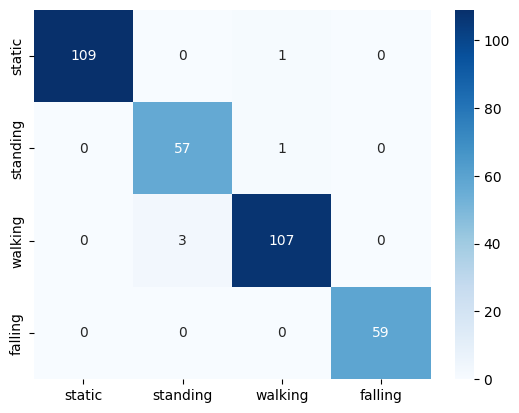

In [37]:
seaborn.heatmap(confusion_matrix(y_val_single, y_pred_single), fmt='g', annot=True, cmap='Blues', xticklabels=targets, yticklabels=targets)

In [38]:
model.save("current_best_network.h5")

In [ ]:
# x_all = loadFromDat(f"./{test_dir}/falling.pcap")